Authors:
Amir Eskanlou (eskanlou@stanford.edu);
 David Zhen Yin (yinzhen@stanford.edu)

---

This tutorial demonstrates multi-dimensional Gaussian Process Regression (GPR) with variogram-based spatial modeling in Python, applied to Density Functional Theory (DFT) computational datasets relevant to mineral processing. It is a practical, reproducible workflow supplementing the paper:

*The Use of Gaussian Process Regression in Modelling Computational and Experimental Mineral Processing Data*

**Learning Objectives:**

- Fit and interpret empirical variograms from sparse DFT datasets.

- Build GPR models that capture spatial correlation in high-dimensional descriptor space.

- Generate conditional and unconditional realizations to assess variability.

- Quantify uncertainty in computational chemistry predictions.

- Visualize 2D, 3D, and 4D spatial fields for interpretation.

**Case Study:**
We use a DFT-derived dataset for 22 molecules relevant to froth flotation, containing:

- Dipole moment (μ)

- LUMO energy (lumo)

- HOMO–LUMO gap (gap)

- Polarizability (α)

The dataset also includes adsorption energies (kJ/mol) of these molecules on a mineral surface, computed via ab initio DFT.

**Goal:**
Use variogram-based GPR to:

- Predict adsorption energies from molecular descriptors.

- Quantify prediction uncertainty.

- Map adsorption energy distributions in descriptor space to guide intelligent reagent design for strong mineral–reagent binding.

### Install and Load Necessary Packages

In [ ]:
! pip install gstools -qq
! pip install scikit-gstat  -qq
! pip install seaborn==0.13.2 -qq
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import RegularGridInterpolator
import plotly.graph_objects as go
from tqdm import trange  # or tqdm
import plotly.express as px
import skgstat as skg
import gstools as gs
import seaborn as sns
import pandas as pd
import numpy as np
# ------------------------------------------------------------------
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['xtick.labelsize'] = 12        # x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12        # y-axis tick labels
plt.rcParams['axes.labelsize'] = 14         # x and y axis labels
plt.rcParams['axes.titlesize'] = 14         # axes title
plt.rcParams['legend.fontsize'] = 14        # legend font size
plt.rcParams['legend.title_fontsize'] = 14  # legend title font size
plt.rcParams['lines.linewidth'] = 2         # line width
plt.rcParams['grid.alpha'] = 0.3            # grid transparency
plt.rcParams['grid.linestyle'] = '--'       # dashed grid

### Load the Dataset

In [ ]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/vvjpacm6eu8zcxvf6py1e/data-22-3D.csv?rlkey=eft1o8578isktj14y92hhgt7h&st=6000t1tc&dl=1')

y = df['energy'].to_numpy()       # Adsorption Energy (kJ/mol)
x1  = df['mu'].to_numpy()         # Dipole Moment/ mu (Debye)
x2 = df['gap'].to_numpy()         # HOMO-LUMO Gap (Hartree)
x3 = df['lumo'].to_numpy()        # LUMO (Hartree)
x4 = df['alpha'].to_numpy()       # Polarizability (Å³)

### Scale the Input Data

In [ ]:
# Normalize molecular descriptor variables to [0, 1] range
# This step ensures all descriptors are on the same scale,
# which is important for variogram modeling and GPR, since
# differences in magnitude could bias distance-based calculations.
# The transformation is: (value - min) / (max - min)

x1_s = (x1 - x1.min()) / (x1.max() - x1.min())  # Scaled dipole moment (mu)
x2_s = (x2 - x2.min()) / (x2.max() - x2.min())  # Scaled LUMO energy
x3_s = (x3 - x3.min()) / (x3.max() - x3.min())  # Scaled HOMO–LUMO gap
x4_s = (x4 - x4.min()) / (x4.max() - x4.min())  # Scaled polarizability (alpha)

X = np.column_stack([x1_s, x2_s, x3_s, x4_s])   # Inputs
y = df['energy'].to_numpy()                     # Adsorption Energy (kJ/mol)

### 2D Case: x₁ and x₂ vs. y

In this section, we examine a two-dimensional case, using the first two normalized molecular descriptors (x₁, x₂) as inputs to predict the target variable (y), the adsorption energy. This simplified scenario allows us to visualize the Gaussian Process Regression results in both the prediction and uncertainty domains, making it easier to interpret spatial patterns before extending the approach to higher dimensions.

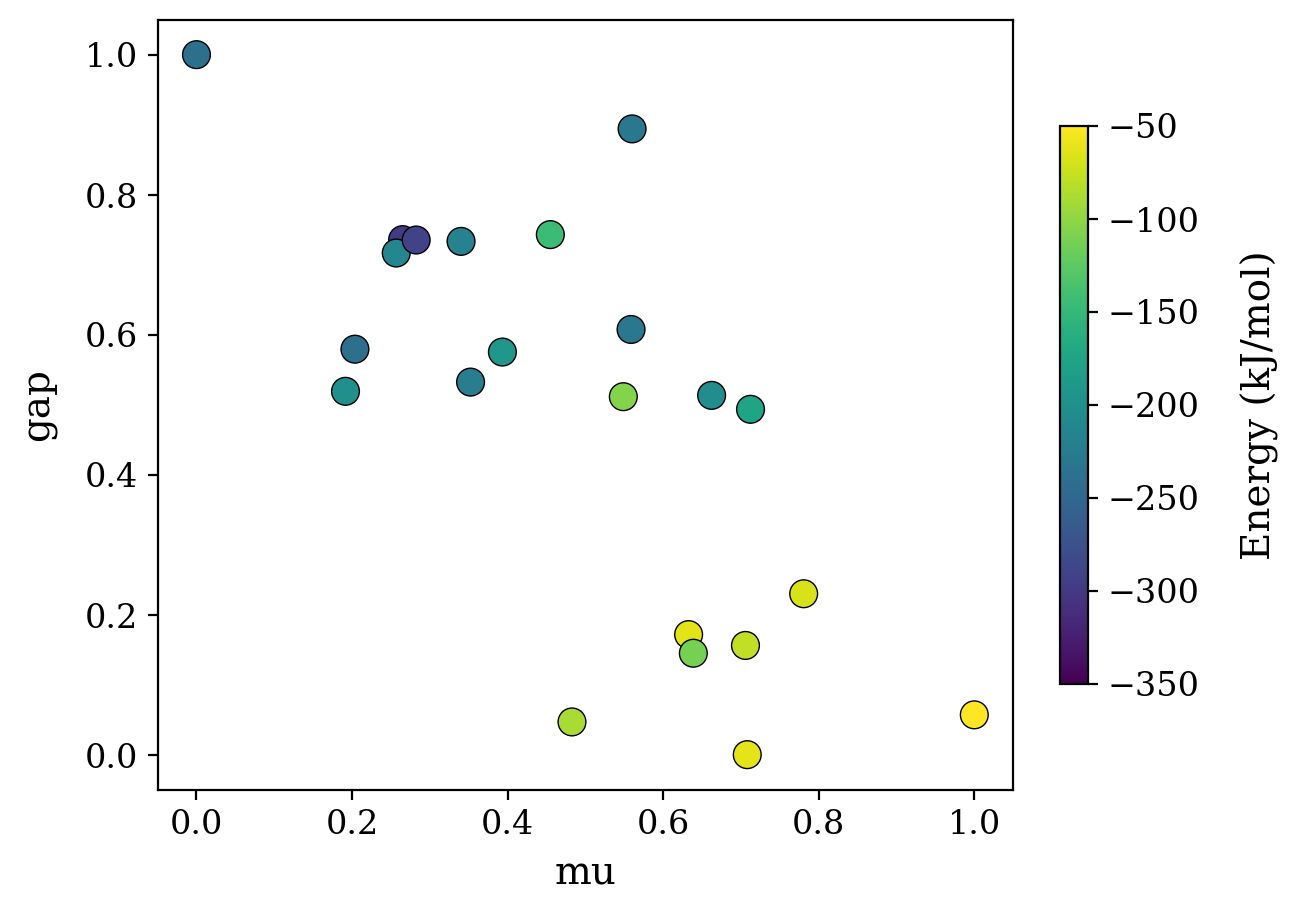

In [ ]:
# Create figure with defined size
plt.figure(figsize=(6, 5))

# Scatter plot: mu vs. gap, colored by adsorption energy
plt.scatter(X[:,0], X[:,1], c=y, s=100, vmax=-50, vmin=-350, edgecolors='k', linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(fraction=0.03, pad=0.05)

# Style and label colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Energy (kJ/mol)', fontsize=14, rotation=90, labelpad=15)

# Label axes
plt.xlabel('mu', labelpad=5)
plt.ylabel('gap', labelpad=10)

plt.show()

## Variogram Modeling in 2D

In [ ]:
skg.plotting.backend('plotly')
Vario = skg.DirectionalVariogram(X[:,[0,1]], y, model='gaussian',
                                 maxlag=0.40, azimuth=0, tolerance=180,  bandwidth='q99',
                                  fit_method='manual', fit_sill=10000, fit_nugget=1500, fit_range=1.7,
                                 n_lags=7, normalize=False)
fig = Vario.plot(show=False)
fig.update_layout(font=dict(family="Times New Roman", size=15, color="black"),
                  width=800, height=450, margin=dict(l=60, r=30, t=30, b=60))
fig.show()

r, s, n = Vario.parameters
print('Variogram parameters:')
print(f"range  = {r:.3f}")
print(f"sill   = {s:.3f}")
print(f"nugget = {n:.3f}")

Variogram parameters:
range  = 1.700
sill   = 10000.000
nugget = 0.000


### Universal Kriging (with trend function)

*Define a linear trend function for the universal kriging*

$$ energy = a*mu + b*gap + c$$

In [ ]:
# fit a bivariate linear trend model

des_mat = np.c_[X[:,[0,1]], np.ones_like(X[:,0])]
# solve for coefficients: [a, b, c]
coeffs, *_ = np.linalg.lstsq(des_mat, y, rcond=None)
a, b, c = coeffs
# print trend function
print(f"trend model: y = {a:.2f} * mu + {b:.2f} * gap + {c:.2f}")

def trend_func(mu,gap):
    # x1 is mu; x2 is gap
    trend = a*mu + b * gap  + c
    return trend

trend model: y = 113.01 * mu + -174.20 * gap + -138.01


In [ ]:
# UK model
model = gs.Gaussian(dim=2, var=10000, len_scale=0.2, nugget=200)

# conditions
cond_pos = (X[:,0], X[:,1])
cond_val = y

# kriging
u_krige = gs.krige.Universal(model, cond_pos, cond_val, drift_functions=[trend_func], exact=True)

## GPR using Universlal Kriging

**Unconditional GPR on Structured Grid**

In [ ]:
# create a random field (unconditional)
uncond_srf = gs.SRF(model, mean=0)  # set mean= desired value

# structured grid
grid_size = 0.02
x_srf = np.arange(-0.1, 1.1, grid_size)
y_srf = np.arange(-0.1, 1.1, grid_size)
uncond_srf.set_pos([x_srf, y_srf], "structured")

# realizations with progress bar
ens_no = 300
all_uncond_realizations = []
seed = gs.random.MasterRNG(20170519)

for i in trange(ens_no, desc="Running unconditional GPR simulation"):
    uncond_srf(seed=seed())
    all_uncond_realizations.append(uncond_srf.field.copy())

all_uncond_realizations = np.array(all_uncond_realizations)  # shape (ens_no, nx, ny)

Running unconditional GPR simulation: 100%|██████████| 300/300 [00:51<00:00,  5.83it/s]


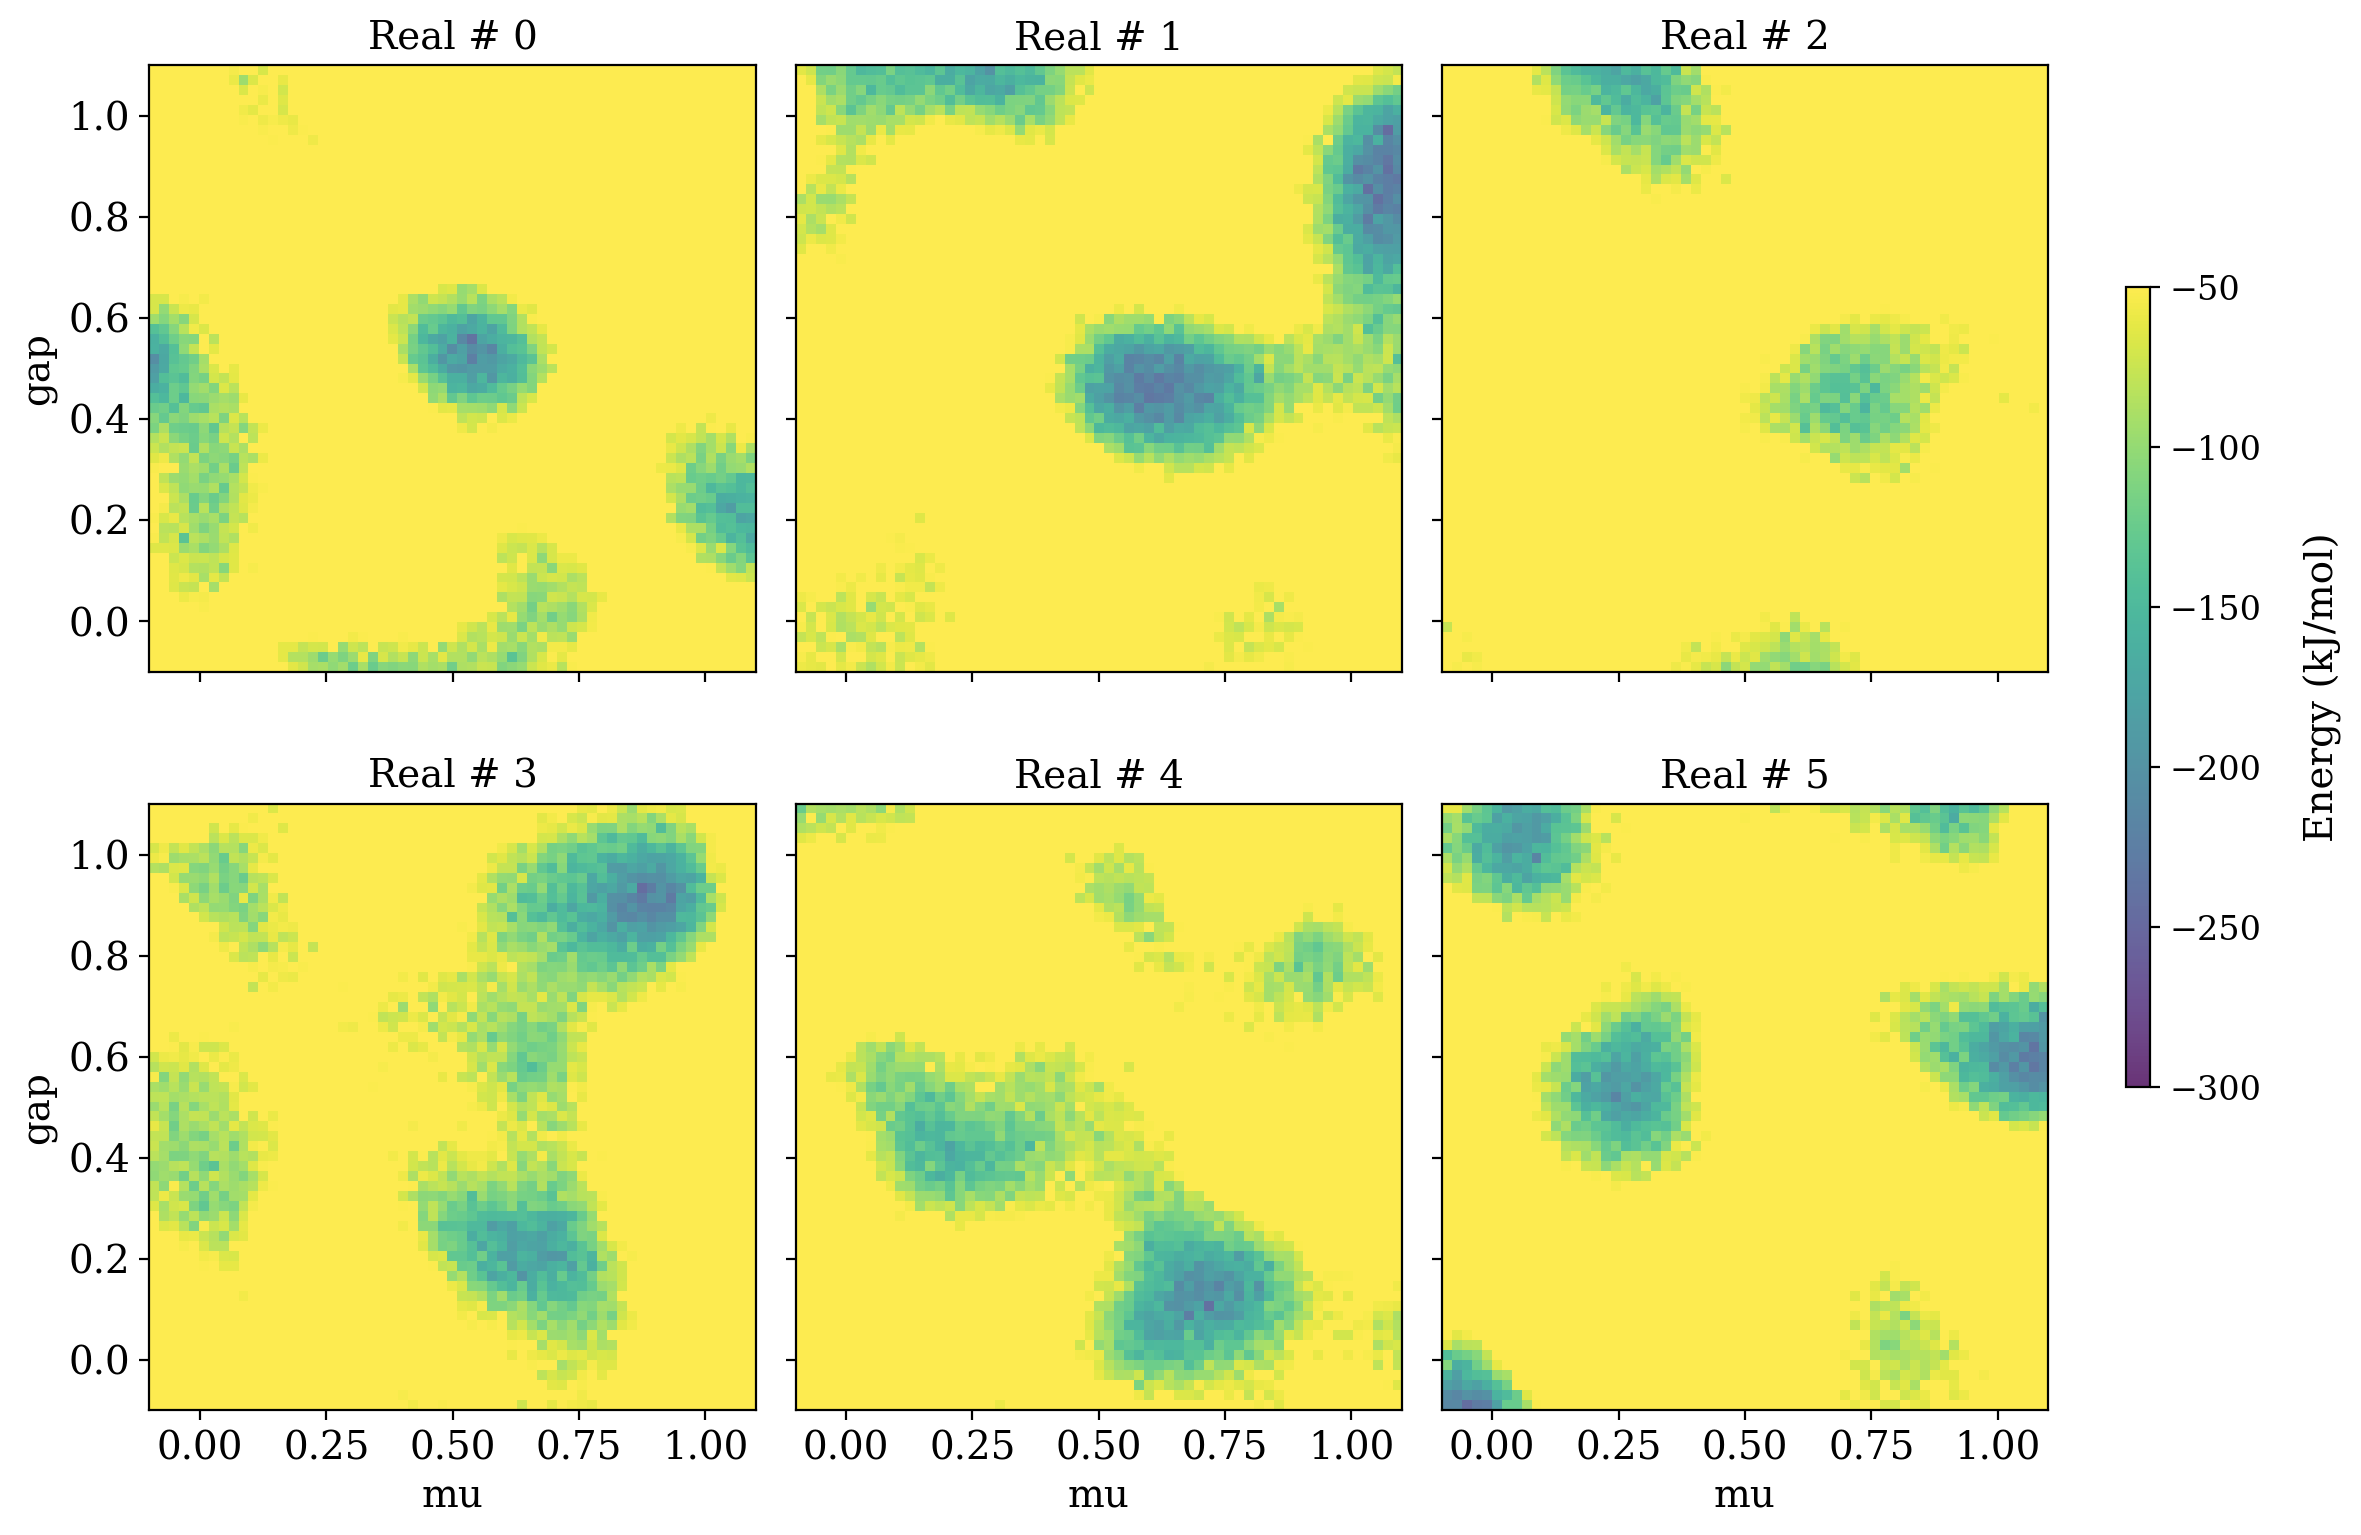

In [ ]:
# plot first six realizations

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(6):
    im = axes[i].imshow(
        all_uncond_realizations[i].T,
        origin='lower',
        extent=[x_srf.min(), x_srf.max(), y_srf.min(), y_srf.max()],
        cmap='viridis',
        vmin=-300, vmax=-50, alpha=0.8
    )
    axes[i].set_title(f'Real # {i}', fontsize=14)
    axes[i].set_xlabel('mu', fontsize=14)
    axes[i].set_ylabel('gap', fontsize=14)
    axes[i].tick_params(labelsize=14)

for ax in axes:
    ax.label_outer()

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.3, 0.01, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Energy (kJ/mol)', fontsize=14, rotation=90, labelpad=15)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

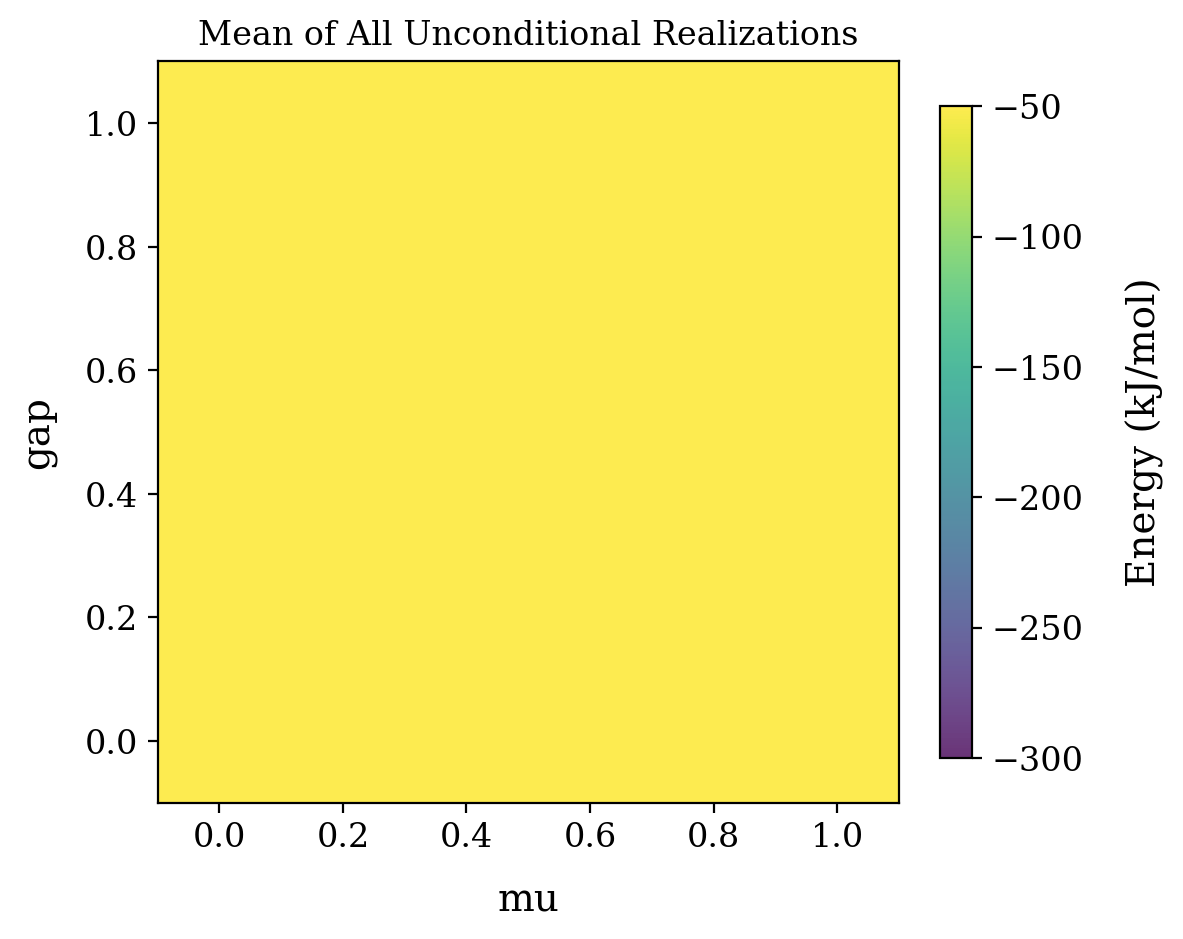

In [ ]:
# plot the mean realization for the unconditional GPR

mean_uncond = all_uncond_realizations.mean(axis=0)
var_uncond = all_uncond_realizations.var(axis=0)
std_uncond = all_uncond_realizations.std(axis=0)

plt.figure(figsize=(6, 6))
im = plt.imshow(
    mean_uncond.T, origin='lower',
    extent=[x_srf.min(), x_srf.max(), y_srf.min(), y_srf.max()],
    vmin=-300, vmax=-50, alpha=0.8
)
cbar = plt.colorbar(im, fraction=0.04, pad=0.05)
cbar.set_label('Energy (kJ/mol)', fontsize=14, rotation=90, labelpad=15)
cbar.ax.tick_params(labelsize=12)
plt.xlabel('mu', labelpad=10)
plt.ylabel('gap', labelpad=10)
plt.title('Mean of All Unconditional Realizations', fontsize=12)
plt.tight_layout()
plt.show()

**Conditional Gaussian Simulation on Structured Grid with UK**

In [ ]:
cond_srf = gs.CondSRF(u_krige)

# create structured grid
gird_size = 0.02
x_srf = np.arange(-0.1, 1.1, gird_size)
y_srf = np.arange(-0.1, 1.1, gird_size)
cond_srf.set_pos([x_srf, y_srf], "structured")

# run simulation
seed = gs.random.MasterRNG(20170519)
ens_no = 300  # number of realizations

for i in trange(ens_no, desc="Running conditional GPR simulation"):
    cond_srf(seed=seed(), store=[f"fld{i}", False, False])

Running conditional GPR simulation: 100%|██████████| 300/300 [00:52<00:00,  5.68it/s]


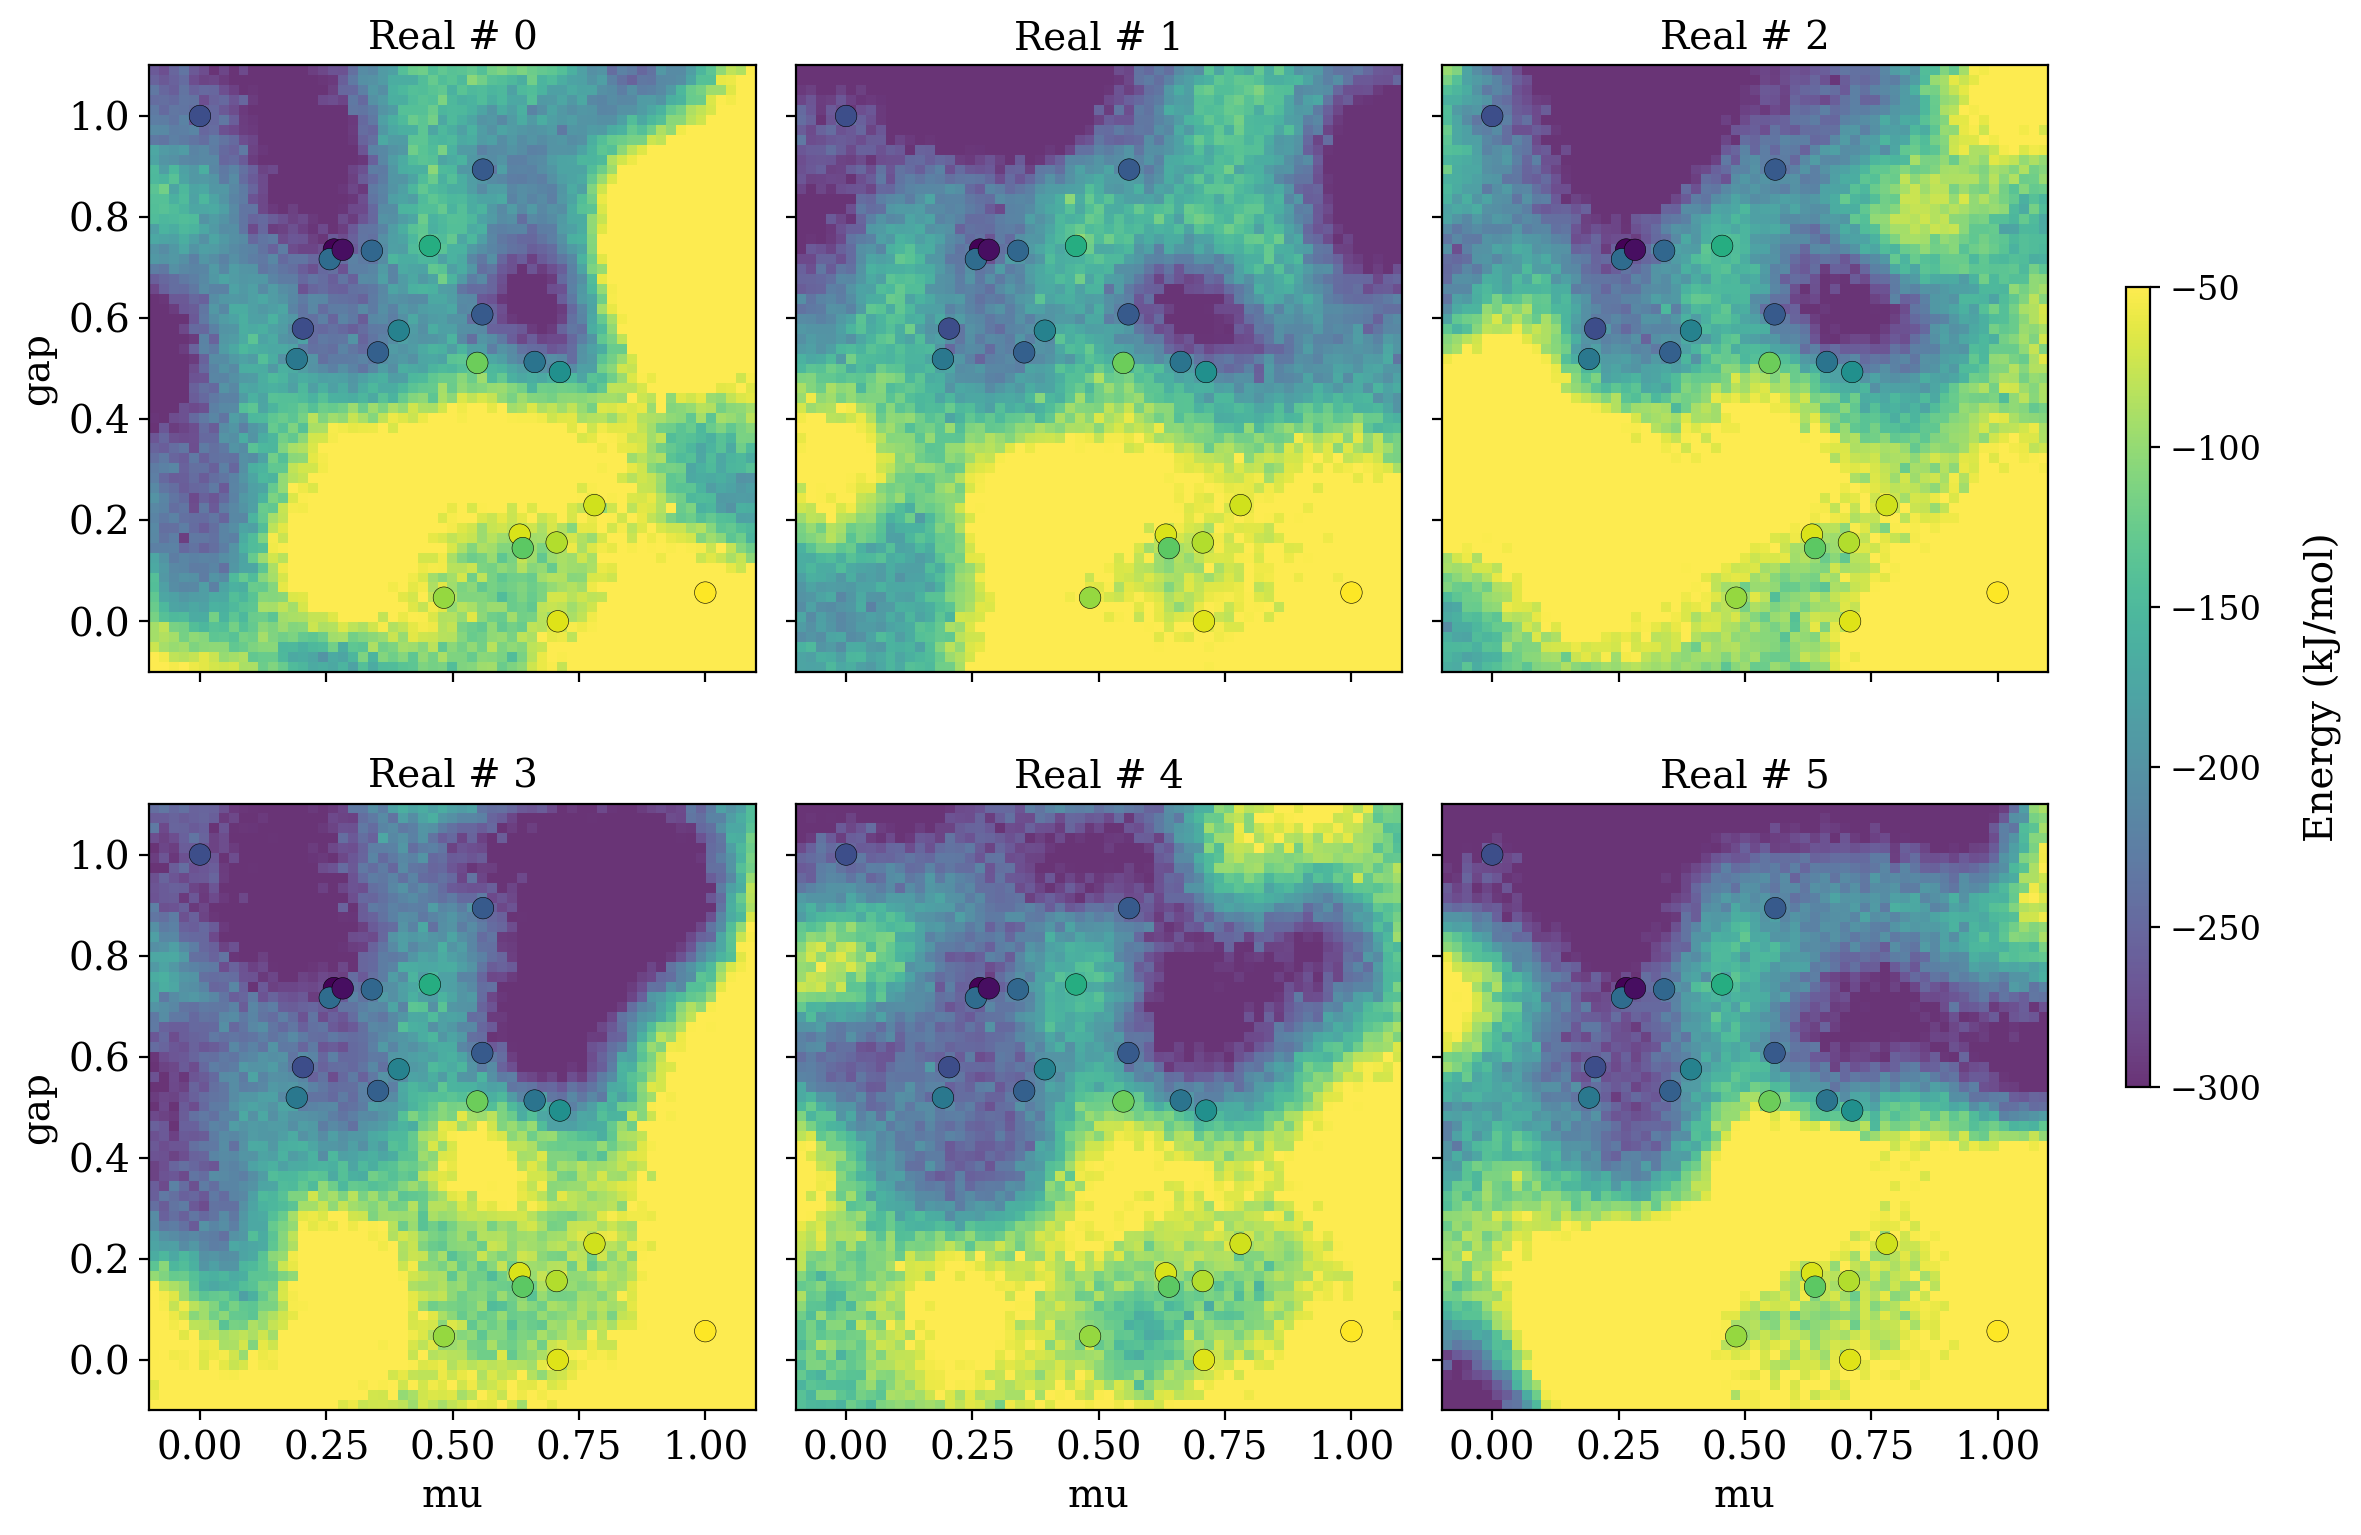

In [ ]:
# plot first six realizations

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(6):
    im = axes[i].imshow(
        cond_srf[i].T,
        origin='lower',
        extent=[x_srf.min(), x_srf.max(), y_srf.min(), y_srf.max()],
        cmap='viridis',
        vmin=-300, vmax=-50, alpha=0.8
    )
    axes[i].scatter(X[:,0], X[:,1], c=y, s=60, vmax=-50, vmin=-300, edgecolors='k', linewidths=0.2)
    axes[i].set_title(f'Real # {i}', fontsize=14)
    axes[i].set_xlabel('mu', fontsize=14)
    axes[i].set_ylabel('gap', fontsize=14)
    axes[i].tick_params(labelsize=14)

for ax in axes:
    ax.label_outer()

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.3, 0.01, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Energy (kJ/mol)', fontsize=14, rotation=90, labelpad=15)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

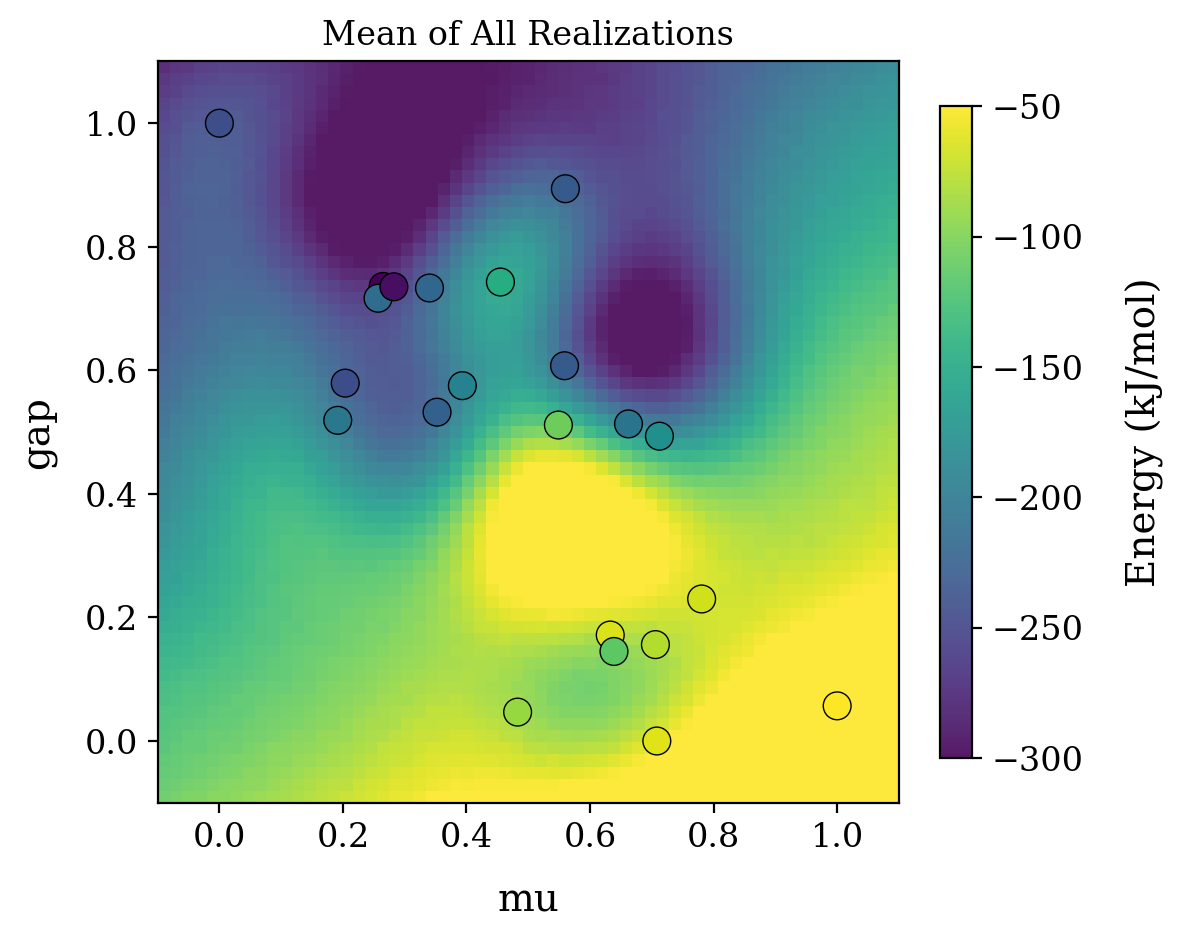

In [ ]:
# mean realization

# stack all realizations into a 3D array: (ens_no, len(x), len(y))
all_realizations = np.array([cond_srf[i] for i in range(ens_no)])

# mean and std dev across realizations (axis=0)
mean_realizations = all_realizations.mean(axis=0)
var_realizations = all_realizations.var(axis=0)
std_realizations  = all_realizations.std(axis=0)

# plot mean realization
plt.figure(figsize=(6, 6))
im = plt.imshow(mean_realizations.T, origin='lower', extent=[x_srf.min(), x_srf.max(), y_srf.min(), y_srf.max()],
           vmin=-300, vmax=-50, alpha=0.9)

plt.scatter(X[:,0], X[:,1], c=y, s=100, vmax=-50, vmin=-300, edgecolors='k', linewidths=0.5, label='Observations')
cbar = plt.colorbar(im, fraction=0.04, pad=0.05)
cbar.set_label('Energy (kJ/mol)', fontsize=14, rotation=90, labelpad=15)
cbar.ax.tick_params(labelsize=12)
plt.xlabel('mu', labelpad=10); plt.ylabel('gap', labelpad=10)
plt.title('Mean of All Realizations', fontsize=12)
plt.tight_layout()
plt.show()

### Plot the Variance

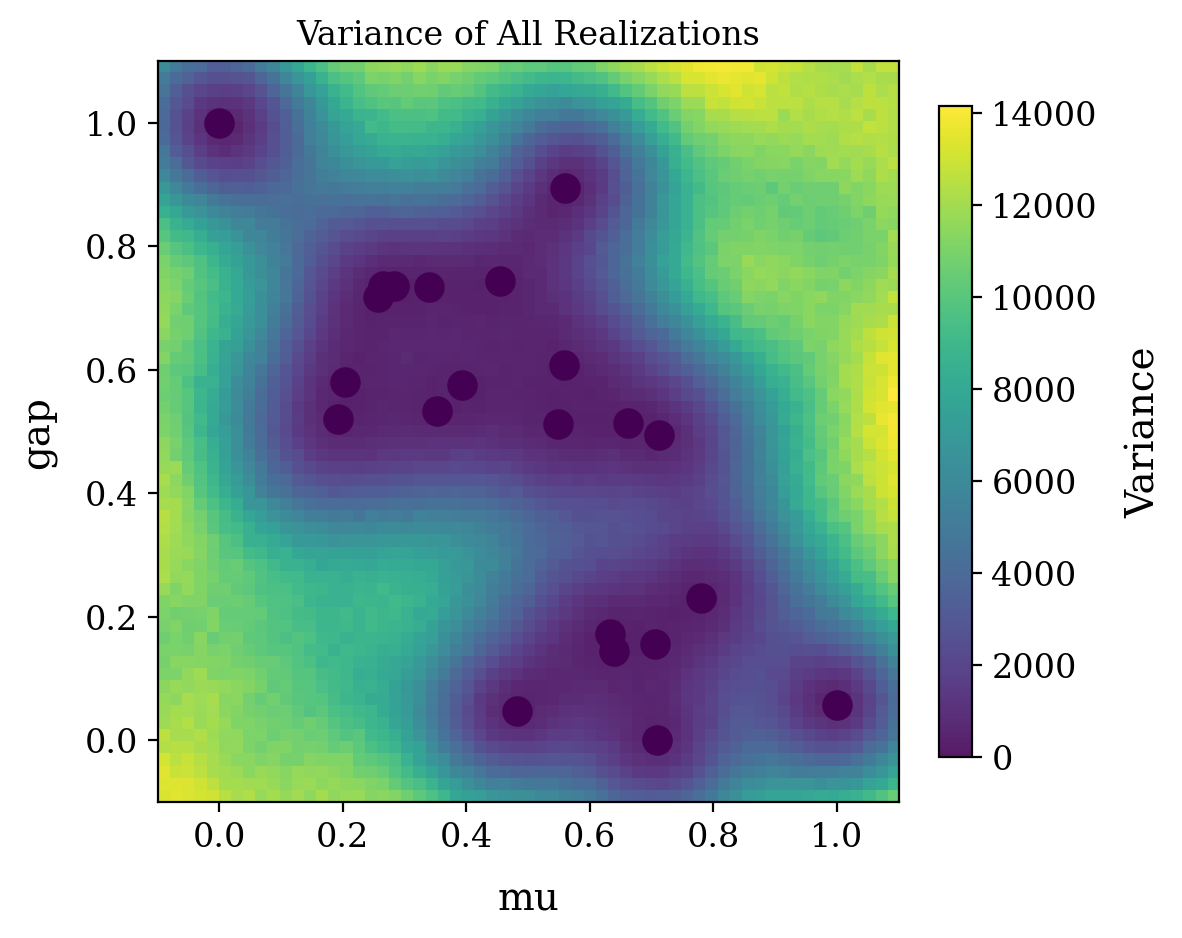

In [ ]:
# copy the variance array so we don't overwrite the original
var_zero = np.copy(var_realizations)

# set variance to zero at the observation points
for pt in X:
    idx_x = np.abs(x_srf - pt[0]).argmin()
    idx_y = np.abs(y_srf - pt[1]).argmin()
    var_zero[idx_x, idx_y] = 0

# set vmax just above maximum variance for better display
var_vmax = np.ceil(var_realizations.max() / 10) * 10

# plot the variance
plt.figure(figsize=(6, 6))
im = plt.imshow(
    var_zero.T, origin='lower', extent=[x_srf.min(), x_srf.max(), y_srf.min(), y_srf.max()],
    alpha=0.9, cmap='viridis', vmin=0, vmax=var_vmax
)
plt.scatter(X[:,0], X[:,1], c='#440154', s=100) # show var=0 at the location of observations
cbar = plt.colorbar(im, fraction=0.04, pad=0.05)
cbar.set_label('Variance', fontsize=14, rotation=90, labelpad=10)
cbar.ax.tick_params(labelsize=12)
plt.title('Variance of All Realizations', fontsize=12)
plt.xlabel('mu', labelpad=10); plt.ylabel('gap', labelpad=10)
plt.tight_layout()
plt.show()

### Plot the Probability Map

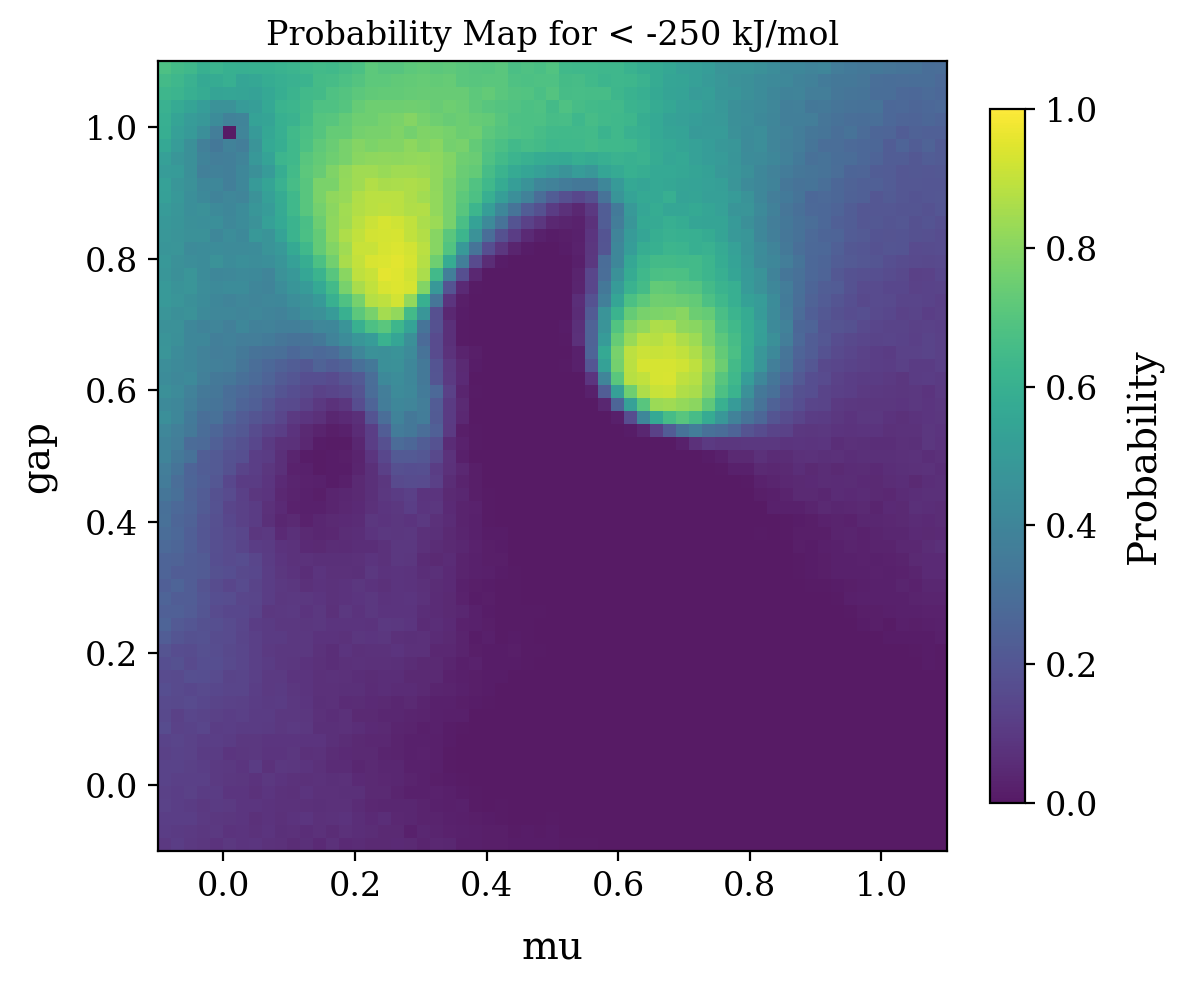

In [ ]:
# compute and plot probability map given a treshold

thresh = -250  # threshold, kJ/mol

# compute the probability map
below_thresh = all_realizations < thresh        # (n_real, nx, ny) boolean array
prob_map = below_thresh.sum(axis=0) / all_realizations.shape[0]  # (nx, ny) probability at each pixel

plt.figure(figsize=(6, 6))
im = plt.imshow(
    prob_map.T,
    origin='lower',
    extent=[x_srf.min(), x_srf.max(), y_srf.min(), y_srf.max()],
    cmap='viridis',
    vmin=0, vmax=1,
    alpha=0.9
)
cbar = plt.colorbar(im, fraction=0.04, pad=0.05)
cbar.set_label(f'Probability', fontsize=14, rotation=90, labelpad=10)
cbar.ax.tick_params(labelsize=12)
plt.xlabel('mu', labelpad=10)
plt.ylabel('gap', labelpad=10)
plt.title(f'Probability Map for < {thresh} kJ/mol', fontsize=12)
plt.tight_layout()
plt.show()

### 3D Case: x₁, x₂, and x₃ vs. y

In this section, we examine a three-dimensional case, using the first three normalized molecular descriptors (x₁, x₂, x₃) as inputs to predict the target variable (y), the adsorption energy. This setup enables us to explore the Gaussian Process Regression results within a more complex descriptor space, capturing interactions that are not visible in the 2D case. Visualizing predictions and uncertainties in three dimensions provides deeper insight into spatial trends, correlation structures, and regions of high or low confidence.

In [ ]:
# plot x₁, x₂, x₃ vs. y

fig = px.scatter_3d(x=x1_s, y=x2_s, z=x3_s, color=y, color_continuous_scale='Viridis')
fig.update_traces(marker=dict(size=6))

fig.update_layout(
    coloraxis_colorbar=dict(title='Energy (kJ/mol)',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        outlinecolor='black', x=0.68, thickness=12, len=0.68, titleside='right'),
    margin=dict(l=0, r=0, b=0, t=0), scene=dict(xaxis=dict(title='mu',
            titlefont=dict(family="Times New Roman", size=20, color='black'),
            tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(title='gap',
            titlefont=dict(family="Times New Roman", size=20, color='black'),
            tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(title='lumo', titlefont=dict(family="Times New Roman", size=20, color='black'),
            tickfont=dict(family="Times New Roman", size=16, color='black'),)))
fig.show()

## Variogram Modeling in 3D

In [ ]:
skg.plotting.backend('plotly')

Vario = skg.Variogram(
    X[:,[0,1,2]], y, model='gaussian',
    maxlag=0.65, n_lags=8,
    fit_method='manual', fit_sill=10000, fit_nugget=100, fit_range=1.7) # normalize=False

fig = Vario.plot(show=False)
fig.update_layout(font=dict(family="Times New Roman", size=15, color="black"),
                  width=800, height=450, margin=dict(l=60, r=30, t=30, b=60))
fig.show()

r, s, n = Vario.parameters
print('Variogram parameters:')
print(f"range  = {r:.3f}")
print(f"sill   = {s:.3f}")
print(f"nugget = {n:.3f}")

Variogram parameters:
range  = 1.700
sill   = 10000.000
nugget = 0.000


### 3D Universal Kriging

*Define a linear trend function for the universal kriging*

$$ energy = a*mu + b*gap + c*lumo + d$$

In [ ]:
# fit a trivariate linear trend model

des_mat = np.c_[x1_s, x2_s, x3_s, np.ones_like(x1_s)]
# solve for coefficients: [a, b, c, d]
coeffs, *_ = np.linalg.lstsq(des_mat, y, rcond=None)
a, b, c, d = coeffs
print(f"trend model: y = {a:.2f} * mu + {b:.2f} * gap + {c:.2f} * lumo + {d:.2f}")

def trend_func(mu, gap, lumo):
    # All must be on same scale as in des_mat!
    trend = a*mu + b*gap + c*lumo + d
    return trend

trend model: y = 111.74 * mu + -93.85 * gap + -103.60 * lumo + -117.79


In [ ]:
# UK model for 3D

model = gs.Gaussian(dim=3, var=10000, len_scale=1.7, nugget=100)

# conditions
cond_pos = (X[:,0], X[:,1], X[:,2]) #(x1_s, x2_s, x3_s)
cond_val = y

# universal kriging with 3-variable trend
u_krige = gs.krige.Universal(model, cond_pos, cond_val, drift_functions=[trend_func], exact=True)

### 3D GPR using Universlal Kriging

**Conditional GPR on Structured Grid**

In [ ]:
grid_size = 0.08  # finer grid sizes will take longer simulation time
x_srf = np.arange(-0.1, 1.1, grid_size)
y_srf = np.arange(-0.1, 1.1, grid_size)
z_srf = np.arange(-0.1, 1.1, grid_size)

cond_srf = gs.CondSRF(u_krige)
cond_srf.set_pos([x_srf, y_srf, z_srf], "structured")

ens_no = 300       # number of realizations
all_cond_realizations = []
seed = gs.random.MasterRNG(20170519)

for i in trange(ens_no, desc="Running 3D conditional GPR simulation", unit="realization"):
    cond_srf(seed=seed())
    all_cond_realizations.append(cond_srf.field.copy())

all_cond_realizations = np.array(all_cond_realizations)  # shape: (ens_no, nx, ny, nz)

Running 3D conditional GPR simulation: 100%|██████████| 300/300 [01:33<00:00,  3.22realization/s]


In [ ]:
# pick one realization

field_s = all_cond_realizations[5] # real. #5
# meshgrid for the volume
X_c, Y_c, Z_c = np.meshgrid(x_srf, y_srf, z_srf, indexing='ij')

nx, ny, nz = field_s.shape
x_idx = nx // 2
y_idx = ny // 2
z_idx = nz // 2

# YZ plane at central X
yz_slice = field_s[x_idx, :, :]
Y1, Z1 = np.meshgrid(y_srf, z_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XZ plane at central Y
xz_slice = field_s[:, y_idx, :]
X2, Z2 = np.meshgrid(x_srf, z_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane at central Z
xy_slice = field_s[:, :, z_idx]
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
Z3 = np.full_like(X3, z_srf[z_idx])

fig = go.Figure()

fig.add_trace(go.Surface(
    x=X1, y=Y1, z=Z1, surfacecolor=yz_slice,
    colorscale='Viridis', showscale=True,
    colorbar=dict(title='Energy (kJ/mol)',
                  titlefont=dict(family='Times New Roman', size=22, color='black'),
            tickfont=dict(family='Times New Roman', size=18, color='black'),
            x=0.69,
            thickness=12,
            len=0.68,
            titleside='right'),
    opacity=1,
    lighting=dict(ambient=1, diffuse=0, fresnel=0, specular=0, roughness=1),))
fig.add_trace(go.Surface(
    x=X2, y=Y2, z=Z2, surfacecolor=xz_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    lighting=dict(ambient=1, diffuse=0, fresnel=0, specular=0, roughness=1),
))
fig.add_trace(go.Surface(
    x=X3, y=Y3, z=Z3, surfacecolor=xy_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    lighting=dict(ambient=1, diffuse=0, fresnel=0, specular=0, roughness=1),))

fig.add_trace(go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=y,
        colorscale='Viridis',
        cmin=y.min(),
        cmax=y.max(),
        line=dict(color='black', width=0.5),)))

fig.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='lumo',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),),
    margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
# calculate and plot mean field

field_m = all_cond_realizations.mean(axis=0)  # (nx, ny, nz)

# meshgrid for the volume (for planes)
X_c, Y_c, Z_c = np.meshgrid(x_srf, y_srf, z_srf, indexing='ij')

nx, ny, nz = field_m.shape
x_idx = nx // 2
y_idx = ny // 2
z_idx = nz // 2

# YZ plane at central X
yz_slice = field_m[x_idx, :, :]
Y1, Z1 = np.meshgrid(y_srf, z_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XZ plane at central Y
xz_slice = field_m[:, y_idx, :]
X2, Z2 = np.meshgrid(x_srf, z_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane at central Z
xy_slice = field_m[:, :, z_idx]
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
Z3 = np.full_like(X3, z_srf[z_idx])

fig = go.Figure()

fig.add_trace(go.Surface(
    x=X1, y=Y1, z=Z1, surfacecolor=yz_slice,
    colorscale='Viridis', showscale=True,
    colorbar=dict(
        title='Energy (kJ/mol)',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        x=0.68,
        thickness=12,
        len=0.69,
        titleside='right'),
    opacity=1,
    lighting=dict(ambient=1, diffuse=0, fresnel=0, specular=0, roughness=1)))
fig.add_trace(go.Surface(
    x=X2, y=Y2, z=Z2, surfacecolor=xz_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    lighting=dict(ambient=1, diffuse=0, fresnel=0, specular=0, roughness=1)))
fig.add_trace(go.Surface(
    x=X3, y=Y3, z=Z3, surfacecolor=xy_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    lighting=dict(ambient=1, diffuse=0, fresnel=0, specular=0, roughness=1)))
fig.add_trace(go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=y,
        colorscale='Viridis',
        cmin=y.min(),
        cmax=y.max(),
        line=dict(color='black', width=0.5),)))

fig.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='lumo',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),),
    margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [ ]:
# plot variance field with zero var at obs locations
# x_srf, y_srf, z_srf are grid axes
# compute variance across all conditional realizations
var_realizations = all_cond_realizations.var(axis=0)  # shape: (nx, ny, nz)

# set variance to zero at observation points
var_zero = np.copy(var_realizations)

nx, ny, nz = var_zero.shape
x_idx = nx // 2
y_idx = ny // 2
z_idx = nz // 2

# grid for the 3 central planes
# YZ plane at central X
yz_slice = var_zero[x_idx, :, :]
Y1, Z1 = np.meshgrid(y_srf, z_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XZ plane at central Y
xz_slice = var_zero[:, y_idx, :]
X2, Z2 = np.meshgrid(x_srf, z_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane at central Z
xy_slice = var_zero[:, :, z_idx]
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
Z3 = np.full_like(X3, z_srf[z_idx])

# colorbar with 0 to 90th percentile
vmin = 0
vmax = np.percentile(var_zero, 90)

fig = go.Figure()

fig.add_trace(go.Surface(
    x=X1, y=Y1, z=Z1, surfacecolor=yz_slice,
    colorscale='Viridis', showscale=True,
    cmin=vmin, cmax=vmax,
    colorbar=dict(
        title='Variance',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        x=0.68, thickness=12, len=0.69, titleside='right'),
    opacity=1,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f'Var: mu={x_srf[x_idx]:.2f}'
))
fig.add_trace(go.Surface(
    x=X2, y=Y2, z=Z2, surfacecolor=xz_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=vmin, cmax=vmax,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f'Var: gap={y_srf[y_idx]:.2f}'
))
fig.add_trace(go.Surface(
    x=X3, y=Y3, z=Z3, surfacecolor=xy_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=vmin, cmax=vmax,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f'Var: lumo={z_srf[z_idx]:.2f}'
))

fig.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='lumo',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black'),
                   range=[-0.1, 1.1]),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black'),
                   range=[-0.1, 1.1]),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black'),
                   range=[-0.1, 1.1]),
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    title="Variance (colorbar max = 90th percentile)"
)
fig.show()

### Plot the Probability Map

In [ ]:
# compute probability map
thresh = -250  # kJ/mol, set threshold
below_thresh = all_cond_realizations < thresh                   # shape: (n_real, nx, ny, nz)
prob_map = below_thresh.sum(axis=0) / all_cond_realizations.shape[0]  # shape: (nx, ny, nz)

# central slice indices
nx, ny, nz = prob_map.shape
x_idx, y_idx, z_idx = nx // 2, ny // 2, nz // 2

# extract central slices
yz_slice = prob_map[x_idx, :, :]   # at fixed x (mu)
xz_slice = prob_map[:, y_idx, :]   # at fixed y (gap)
xy_slice = prob_map[:, :, z_idx]   # at fixed z (lumo)

# build coordinate grids for each plane
Y1, Z1 = np.meshgrid(y_srf, z_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

X2, Z2 = np.meshgrid(x_srf, z_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
Z3 = np.full_like(X3, z_srf[z_idx])

# color scaling
vmin = 0.0
vmax = float(np.percentile(prob_map, 90))  #

# plot three surface slices
fig = go.Figure()

# YZ plane (at μ = x_srf[x_idx])
fig.add_trace(go.Surface(
    x=X1, y=Y1, z=Z1, surfacecolor=yz_slice,
    colorscale='Viridis', showscale=True, cmin=vmin, cmax=vmax,
    colorbar=dict(
        title='Probability',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        x=0.68, thickness=12, len=0.69, titleside='right'
    ),
    opacity=1.0,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f'P: μ={x_srf[x_idx]:.2f}'
))

# XZ plane (at gap = y_srf[y_idx])
fig.add_trace(go.Surface(
    x=X2, y=Y2, z=Z2, surfacecolor=xz_slice,
    colorscale='Viridis', showscale=False, cmin=vmin, cmax=vmax,
    opacity=1.0,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f'P: gap={y_srf[y_idx]:.2f}'
))

# XY plane (at lumo = z_srf[z_idx])
fig.add_trace(go.Surface(
    x=X3, y=Y3, z=Z3, surfacecolor=xy_slice,
    colorscale='Viridis', showscale=False, cmin=vmin, cmax=vmax,
    opacity=1.0,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f'P: lumo={z_srf[z_idx]:.2f}'
))

# layout & axes
fig.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='lumo',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black'),
                   range=[x_srf.min(), x_srf.max()]),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black'),
                   range=[y_srf.min(), y_srf.max()]),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black'),
                   range=[z_srf.min(), z_srf.max()]),
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    title=f"Probability(< {thresh} kJ/mol) — colorbar max = 90th percentile"
)

fig.show()

### 4D Case: x₁, x₂, x₃, and x₄ vs. y

In this section, we extend the analysis to a four-dimensional case, using all four normalized molecular descriptors (x₁, x₂, x₃, x₄) as inputs to predict the target variable (y), the adsorption energy. This four-dimensional setup enables the GPR model to capture the most detailed and realistic representation of the underlying structure–property relationships. By modeling in 4D space, we account for complex interactions and dependencies among all descriptors simultaneously. While direct visualization becomes more challenging in higher dimensions, we leverage techniques such as slicing, projection, and probability mapping to interpret both the predictions and the associated uncertainties within this expanded feature space.

In [ ]:
# plot data

marker_scale = 15
x4_scaled = x4_s * marker_scale

fig = px.scatter_3d(
    x=x1_s, y=x2_s, z=x3_s,
    color=y,
    size=x4_scaled,
    color_continuous_scale='Viridis',)

fig.update_traces(marker=dict(
    sizemode='diameter',
    sizemin=6,       # minimum marker size
    sizeref=0.15,))

fig.update_layout(
    coloraxis_colorbar=dict(
        title='Energy (kJ/mol)',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        outlinecolor='black', x=0.70, thickness=14, len=0.66, titleside='right'),
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='mu', titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(title='gap', titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(title='lumo', titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        ),
    title=f"Data point size ∝ x4"
    )

fig.show()

## Variogram Modeling in 4D

In [ ]:
# 4D - Variogram
skg.plotting.backend('plotly')

Vario = skg.Variogram(
    X, y, model='gaussian', # spherical
    maxlag=0.65, n_lags=8,
    fit_method='manual', fit_sill=14000, fit_nugget=0, fit_range=1.7) # normalize=False


fig = Vario.plot(show=False)
fig.update_layout(font=dict(family="Times New Roman", size=15, color="black"),
                  width=800, height=450, margin=dict(l=60, r=30, t=30, b=60))
fig.show()

r, s, n = Vario.parameters
print('Variogram parameters:')
print(f"range  = {r:.3f}")
print(f"sill   = {s:.3f}")
print(f"nugget = {n:.3f}")

Variogram parameters:
range  = 1.700
sill   = 14000.000
nugget = 0.000


### Universal Kriging (with trend function)

*Define a linear trend function for the universal kriging*

$$ energy = a*mu + b*gap + c*lumo + d*alpha + e$$

In [ ]:
# 4D - fit a trivariate linear trend model

des_mat = np.c_[x1_s, x2_s, x3_s, x4_s, np.ones_like(x1_s)]
# solve for coefficients: [a, b, c, d]
coeffs, *_ = np.linalg.lstsq(des_mat, y, rcond=None)
a, b, c, d, e = coeffs
print(f"trend model: z = {a:.2f} * mu + {b:.2f} * gap + {c:.2f} * lumo + {d:.2f}*alpha + {e:.2f}")

def trend_func(mu, gap, lumo, alpha):
    # All must be on same scale as in des_mat!
    trend = a*mu + b*gap + c * lumo  + d*alpha + e
    return trend

trend model: z = 109.34 * mu + -98.07 * gap + -99.48 * lumo + -8.33*alpha + -113.97


In [ ]:
# UK model for 4D

model = gs.Gaussian(dim=4, var=12000, len_scale=1.7, nugget=100)

# conditions
cond_pos = (X[:,0], X[:,1], X[:,2], X[:,3]) #(x1_s, x2_s, x3_s, x4_s)
cond_val = y

# universal kriging with 4-variable trend
u_krige = gs.krige.Universal(model, cond_pos, cond_val, drift_functions=[trend_func], exact=True)

### GPR using Universlal Kriging

In [ ]:
# create 4D structured grid
# 5 mins estimated run time

grid_size = 0.04
x_srf = np.arange(-0.1, 1.1, grid_size)
y_srf = np.arange(-0.1, 1.1, grid_size)
z_srf = np.arange(-0.1, 1.1, grid_size)
h_srf = np.arange(-0.1, 1.1, grid_size)

cond_srf = gs.CondSRF(u_krige)
cond_srf.set_pos([x_srf, y_srf, z_srf, h_srf], "structured")

ens_no = 20 # you can reduce number of realizations to reduce running time
all_cond_realizations = []
seed = gs.random.MasterRNG(20170519)

for i in trange(ens_no, desc="Running 4D conditional GPR simulation", unit="realization"):
    cond_srf(seed=seed())
    all_cond_realizations.append(cond_srf.field.copy())

all_cond_realizations = np.array(all_cond_realizations)  # shape: (ens_no, nx, ny, nz, nh)

Running 4D conditional GPR simulation: 100%|██████████| 10/10 [05:28<00:00, 32.86s/realization]


In [ ]:
# plot one realization

real_idx = 0       # which realization
#z_idx = len(z_srf) // 2   # slice for lumo (x3)

z_idx = np.abs(z_srf - 0.75).argmin() # plot in 3D at a certain slice of x4

# 3D field at fixed lumo
field_3d = all_cond_realizations[real_idx][:, :, z_idx, :]  # (nx, ny, nh)

# meshgrid for surfaces (mu, gap, alpha)
X_c, Y_c, H_c = np.meshgrid(x_srf, y_srf, h_srf, indexing='ij')
nx, ny, nh = field_3d.shape
x_idx = nx // 2
y_idx = ny // 2
h_idx = nh // 2

# crossing planes for 3D visualization
# YH plane at central mu
yh_slice = field_3d[x_idx, :, :]
Y1, H1 = np.meshgrid(y_srf, h_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XH plane at central gap
xh_slice = field_3d[:, y_idx, :]
X2, H2 = np.meshgrid(x_srf, h_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane at central alpha
xy_slice = field_3d[:, :, h_idx]
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
H3 = np.full_like(X3, h_srf[h_idx])

cmin = -300
cmax = -50

fig = go.Figure()

fig.add_trace(go.Surface(
    x=X1, y=Y1, z=H1, surfacecolor=yh_slice,
    colorscale='Viridis', showscale=True,
    cmin=cmin, cmax=cmax,
    colorbar=dict(title='Energy (kJ/mol)',
                  titlefont=dict(family='Times New Roman', size=22, color='black'),
                  tickfont=dict(family='Times New Roman', size=18, color='black'),
                  x=0.69, thickness=14, len=0.66, titleside='right'),
    opacity=1,
    lighting=dict(ambient=0.9, diffuse=0.4, fresnel=0, specular=0, roughness=1),
    name=f"YH at mu={x_srf[x_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"))

fig.add_trace(go.Surface(
    x=X2, y=Y2, z=H2, surfacecolor=xh_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=cmin, cmax=cmax,
    lighting=dict(ambient=0.9, diffuse=0.4, fresnel=0, specular=0, roughness=1),
    name=f"XH at gap={y_srf[y_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"))

fig.add_trace(go.Surface(
    x=X3, y=Y3, z=H3, surfacecolor=xy_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=cmin, cmax=cmax,
    lighting=dict(ambient=0.9, diffuse=0.4, fresnel=0, specular=0, roughness=1),
    name=f"XY at alpha={h_srf[h_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"))

# plot the observed points in mu, gap, alpha (with lumo fixed)
fig.add_trace(go.Scatter3d(
    x=X[:, 0],   # mu
    y=X[:, 1],   # gap
    z=X[:, 3],   # alpha
    mode='markers',
    marker=dict(
        size=6,
        color=y,
        colorscale='Viridis',
        cmin=y.min(), cmax=y.max(),
        line=dict(color='black', width=0.5),
        opacity=1,
        sizemode='diameter',
    ),
))

fig.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='alpha',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    title=f"Realization #{real_idx} at x4 = {z_srf[z_idx]:.2f} (slice)"
)
fig.show()

In [ ]:
# plot mean at lumo ≈ 0.75
z_idx = np.abs(z_srf - 0.75).argmin()  # or another lumo value

# mean field at fixed lumo
field_m = all_cond_realizations.mean(axis=0)    # (nx, ny, nz, nh)
field_3d = field_m[:, :, z_idx, :]              # (nx, ny, nh) at fixed lumo

# meshgrid for surfaces (mu, gap, alpha)
X_c, Y_c, H_c = np.meshgrid(x_srf, y_srf, h_srf, indexing='ij')
nx, ny, nh = field_3d.shape
x_idx = nx // 2
y_idx = ny // 2
h_idx = nh // 2

# crossing planes for 3D visualization
# YH plane at central mu
yh_slice = field_3d[x_idx, :, :]
Y1, H1 = np.meshgrid(y_srf, h_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XH plane at central gap
xh_slice = field_3d[:, y_idx, :]
X2, H2 = np.meshgrid(x_srf, h_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane at central alpha
xy_slice = field_3d[:, :, h_idx]
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
H3 = np.full_like(X3, h_srf[h_idx])

cmin = -300
cmax = -50

fig = go.Figure()

fig.add_trace(go.Surface(
    x=X1, y=Y1, z=H1, surfacecolor=yh_slice,
    colorscale='Viridis', showscale=True,
    cmin=cmin, cmax=cmax,
    colorbar=dict(title='Energy (kJ/mol)',
                  titlefont=dict(family='Times New Roman', size=22, color='black'),
                  tickfont=dict(family='Times New Roman', size=18, color='black'),
                  x=0.69, thickness=14, len=0.66, titleside='right'),
    opacity=1,
    lighting=dict(ambient=0.9, diffuse=0.4, fresnel=0, specular=0, roughness=1),
    name=f"YH at mu={x_srf[x_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"))

fig.add_trace(go.Surface(
    x=X2, y=Y2, z=H2, surfacecolor=xh_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=cmin, cmax=cmax,
    lighting=dict(ambient=0.9, diffuse=0.4, fresnel=0, specular=0, roughness=1),
    name=f"XH at gap={y_srf[y_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"))

fig.add_trace(go.Surface(
    x=X3, y=Y3, z=H3, surfacecolor=xy_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=cmin, cmax=cmax,
    lighting=dict(ambient=0.9, diffuse=0.4, fresnel=0, specular=0, roughness=1),
    name=f"XY at alpha={h_srf[h_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"))

# plot the observed points in mu, gap, alpha (with lumo fixed)
fig.add_trace(go.Scatter3d(
    x=X[:, 0],   # mu
    y=X[:, 1],   # gap
    z=X[:, 3],   # alpha
    mode='markers',
    marker=dict(
        size=6,
        color=y,
        colorscale='Viridis',
        cmin=y.min(), cmax=y.max(),
        line=dict(color='black', width=0.5),
        opacity=1,
        sizemode='diameter',
    ),
))

fig.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='alpha',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    title=f"Mean Field at lumo = {z_srf[z_idx]:.2f} (slice)"
)
fig.show()

In [ ]:
# plot variance
# choose the same LUMO slice as the mean plot
target_lumo = 0.75
z_idx = np.abs(z_srf - target_lumo).argmin()

# compute variance field
field_v = all_cond_realizations.var(axis=0)    # (nx, ny, nz, nh)
var_3d  = field_v[:, :, z_idx, :]              # (nx, ny, nh)

# force variance = 0 at observed points
lumo_tol = 0.02
var_3d_zero = var_3d.copy()
for pt in X:   # pt = [mu, gap, lumo, alpha]
    if np.abs(pt[2] - z_srf[z_idx]) <= lumo_tol:
        ix = np.abs(x_srf - pt[0]).argmin()
        iy = np.abs(y_srf - pt[1]).argmin()
        ih = np.abs(h_srf - pt[3]).argmin()
        var_3d_zero[ix, iy, ih] = 0.0

# central slice indices
nx, ny, nh = var_3d_zero.shape
x_idx = nx // 2
y_idx = ny // 2
h_idx = nh // 2

# YH plane
vh_yh = var_3d_zero[x_idx, :, :]   # (ny, nh)
Y1, H1 = np.meshgrid(y_srf, h_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XH plane
vh_xh = var_3d_zero[:, y_idx, :]   # (nx, nh)
X2, H2 = np.meshgrid(x_srf, h_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane
vh_xy = var_3d_zero[:, :, h_idx]   # (nx, ny)
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
H3 = np.full_like(X3, h_srf[h_idx])

# colorbar scaling (90th percentile cutoff)
vmin = 0.0
vmax = float(np.percentile(var_3d_zero, 90))

fig_var = go.Figure()

fig_var.add_trace(go.Surface(
    x=X1, y=Y1, z=H1, surfacecolor=vh_yh,
    colorscale='Viridis', cmin=vmin, cmax=vmax,
    showscale=True, opacity=1,
    colorbar=dict(
        title='Variance',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        x=0.69, thickness=14, len=0.66, titleside='right'
    ),
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f"YH at μ={x_srf[x_idx]:.2f}, LUMO={z_srf[z_idx]:.2f}"
))

fig_var.add_trace(go.Surface(
    x=X2, y=Y2, z=H2, surfacecolor=vh_xh,
    colorscale='Viridis', cmin=vmin, cmax=vmax,
    showscale=False, opacity=1,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f"XH at gap={y_srf[y_idx]:.2f}, LUMO={z_srf[z_idx]:.2f}"
))

fig_var.add_trace(go.Surface(
    x=X3, y=Y3, z=H3, surfacecolor=vh_xy,
    colorscale='Viridis', cmin=vmin, cmax=vmax,
    showscale=False, opacity=1,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f"XY at α={h_srf[h_idx]:.2f}, LUMO={z_srf[z_idx]:.2f}"
))

# layout
fig_var.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='alpha',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    title=f"Variance Field at lumo = {z_srf[z_idx]:.2f} (slice)"
)

fig_var.show()

In [ ]:
# plot probability with a treshhold
# settings
thresh = -240
target_lumo = 0.75
z_idx = np.abs(z_srf - target_lumo).argmin()

# probability field at fixed lumo slice

below = all_cond_realizations[:, :, :, z_idx, :] < thresh
prob_3d = below.mean(axis=0)  # (nx, ny, nh)

# central slices
nx, ny, nh = prob_3d.shape
x_idx = nx // 2
y_idx = ny // 2
h_idx = nh // 2

# YH plane at central mu
p_yh = prob_3d[x_idx, :, :]                 # (ny, nh)
Y1, H1 = np.meshgrid(y_srf, h_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XH plane at central gap
p_xh = prob_3d[:, y_idx, :]                 # (nx, nh)
X2, H2 = np.meshgrid(x_srf, h_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane at central alpha
p_xy = prob_3d[:, :, h_idx]                 # (nx, ny)
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
H3 = np.full_like(X3, h_srf[h_idx])

# colorbar scaling
pmin, pmax = 0.0, 1.0

fig_prob = go.Figure()

fig_prob.add_trace(go.Surface(
    x=X1, y=Y1, z=H1, surfacecolor=p_yh,
    colorscale='Viridis', cmin=pmin, cmax=pmax,
    showscale=True, opacity=1,
    colorbar=dict(
        title='Probability',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        x=0.69, thickness=14, len=0.66, titleside='right'
    ),
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f"YH at mu={x_srf[x_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"
))

fig_prob.add_trace(go.Surface(
    x=X2, y=Y2, z=H2, surfacecolor=p_xh,
    colorscale='Viridis', cmin=pmin, cmax=pmax,
    showscale=False, opacity=1,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f"XH at gap={y_srf[y_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"
))

fig_prob.add_trace(go.Surface(
    x=X3, y=Y3, z=H3, surfacecolor=p_xy,
    colorscale='Viridis', cmin=pmin, cmax=pmax,
    showscale=False, opacity=1,
    lighting=dict(ambient=0.7, diffuse=0.5, fresnel=0, specular=0.1, roughness=1),
    name=f"XY at alpha={h_srf[h_idx]:.2f}, lumo={z_srf[z_idx]:.2f}"
))

fig_prob.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='alpha',
        aspectmode='cube',
        xaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        yaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
        zaxis=dict(titlefont=dict(family="Times New Roman", size=20, color='black'),
                   tickfont=dict(family="Times New Roman", size=16, color='black')),
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    title=f"Probability (Y < {thresh}) at lumo = {z_srf[z_idx]:.2f} (slice)"
)

fig_prob.show()

### Polynomial Fit in 3D

In [ ]:
# Do a polynomial fit for 3D case to compare with GPR

from itertools import product

X_pf = X[:,[0,1,2]]

degree = 2              # second degree

def nd_polyfit(X_pf, values, degree):
    """
    Fit an n-dimensional polynomial of given degree to data.

    Parameters:
    - X_pf: array of shape (N, D), where N = number of samples, D = dimension
    - values: array of shape (N,), target values
    - degree: int, polynomial degree

    Returns:
    - coeffs: fitted polynomial coefficients
    - powers: list of tuples, each representing the power of a term
    """
    N, D = X_pf.shape

    def poly_terms(X):
        terms = []
        powers = []
        for exps in product(range(degree + 1), repeat=D):
            if sum(exps) <= degree:
                term = np.prod(X**exps, axis=1)
                terms.append(term)
                powers.append(exps)
        return np.vstack(terms).T, powers

    A, powers = poly_terms(X_pf)
    coeffs, _, _, _ = np.linalg.lstsq(A, values, rcond=None)
    return coeffs, powers

def nd_polyeval(X_pf, coeffs, powers):
    """
    Evaluate the fitted polynomial at given coordinates.

    Parameters:
    - X_pf: array of shape (N, D)
    - coeffs: coefficients from nd_polyfit
    - powers: exponent tuples

    Returns:
    - values: array of shape (N,), evaluated results
    """
    values = np.zeros(X_pf.shape[0])
    for coef, power in zip(coeffs, powers):
        term = np.prod(X_pf**power, axis=1)
        values += coef * term
    return values

In [ ]:
# Fit a 3D polynomial of degree 2
coeffs, powers = nd_polyfit(X_pf, y, degree=2)

# Create structured grid
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1; z_min, z_max = -0.1, 1.1
x = np.arange(x_min, x_max, 0.01)
y = np.arange(y_min, y_max, 0.01); z= np.arange(z_min, z_max, 0.01)
xx, yy, zz = np.meshgrid(x, y, z)

coords_new = np.vstack((xx.ravel(), yy.ravel(), zz.ravel())).T

# Evaluate polynomial on grid
poly_result = nd_polyeval(coords_new, coeffs, powers)

In [ ]:
# plot in 3D

# extent for focus
x_srf = np.linspace(-0.1, 1.1, 31)
y_srf = np.linspace(-0.1, 1.1, 31)
z_srf = np.linspace(-0.1, 1.1, 31)

x_121 = np.linspace(-0.1, 1.1, 121)
y_121 = np.linspace(-0.1, 1.1, 121)
z_121 = np.linspace(-0.1, 1.1, 121)
poly_grid_121 = poly_result.reshape(121, 121, 121)

# 31x31x31 grid
Xc, Yc, Zc = np.meshgrid(x_srf, y_srf, z_srf, indexing='ij')
interp_func = RegularGridInterpolator((x_121, y_121, z_121), poly_grid_121, bounds_error=False, fill_value=np.nan)
points = np.stack([Xc.ravel(), Yc.ravel(), Zc.ravel()], axis=-1)
poly_grid_31 = interp_func(points).reshape(31, 31, 31)

# central indices
nx, ny, nz = poly_grid_31.shape
x_idx = nx // 2
y_idx = ny // 2
z_idx = nz // 2

# YZ plane at central X
yz_slice = poly_grid_31[x_idx, :, :]
Y1, Z1 = np.meshgrid(y_srf, z_srf, indexing='ij')
X1 = np.full_like(Y1, x_srf[x_idx])

# XZ plane at central Y
xz_slice = poly_grid_31[:, y_idx, :]
X2, Z2 = np.meshgrid(x_srf, z_srf, indexing='ij')
Y2 = np.full_like(X2, y_srf[y_idx])

# XY plane at central Z
xy_slice = poly_grid_31[:, :, z_idx]
X3, Y3 = np.meshgrid(x_srf, y_srf, indexing='ij')
Z3 = np.full_like(X3, z_srf[z_idx])

# colorbar range
vmin = -300
vmax = -50

fig = go.Figure()

fig.add_trace(go.Surface(
    x=X1, y=Y1, z=Z1, surfacecolor=yz_slice,
    colorscale='Viridis', showscale=True,
    cmin=vmin, cmax=vmax,
    colorbar=dict(
        title='Energy (kJ/mol)',
        titlefont=dict(family='Times New Roman', size=22, color='black'),
        tickfont=dict(family='Times New Roman', size=18, color='black'),
        x=0.68,
        thickness=12,
        len=0.69,
        titleside='right'),
    opacity=1,
    lighting=dict(ambient=0.9, diffuse=0.2, fresnel=0, specular=0, roughness=1),
    name=f'Poly fit: mu={x_srf[x_idx]:.2f}'))
fig.add_trace(go.Surface(
    x=X2, y=Y2, z=Z2, surfacecolor=xz_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=vmin, cmax=vmax,
    lighting=dict(ambient=0.9, diffuse=0.2, fresnel=0, specular=0, roughness=1),
    name=f'Poly fit: gap={y_srf[y_idx]:.2f}'))
fig.add_trace(go.Surface(
    x=X3, y=Y3, z=Z3, surfacecolor=xy_slice,
    colorscale='Viridis', showscale=False, opacity=1,
    cmin=vmin, cmax=vmax,
    lighting=dict(ambient=0.9, diffuse=0.2, fresnel=0, specular=0, roughness=1),
    name=f'Poly fit: lumo={z_srf[z_idx]:.2f}'))

fig.add_trace(go.Scatter3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=y,
        colorscale='Viridis',
        cmin=y.min(),
        cmax=y.max(),
        line=dict(color='black', width=0.5),)))

fig.update_layout(
    scene=dict(
        xaxis_title='mu',
        yaxis_title='gap',
        zaxis_title='lumo',
        aspectmode='cube',
        xaxis=dict(
            titlefont=dict(family="Times New Roman", size=20, color='black'),
            tickfont=dict(family="Times New Roman", size=16, color='black'),
            range=[-0.1, 1.1]),
        yaxis=dict(
            titlefont=dict(family="Times New Roman", size=20, color='black'),
            tickfont=dict(family="Times New Roman", size=16, color='black'),
            range=[-0.1, 1.1]),
        zaxis=dict(
            titlefont=dict(family="Times New Roman", size=20, color='black'),
            tickfont=dict(family="Times New Roman", size=16, color='black'),
            range=[-0.1, 1.1]),),
    margin=dict(l=0, r=0, t=30, b=0),
    title=f'Polynomial Fitting (deg={degree}) - 3D Planes')
fig.show()